In [ ]:
#| default_exp registration

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import timm
import torch

## Training

We perform patient-specific X-ray to CT registration by pre-training an encoder/decoder architecture. The encoder, `PoseRegressor`, is comprised of two networks:

1. A pretrained backbone (i.e., convolutional or transformer network) that extracts features from an input X-ray image.
2. A set of two linear layers that decodes these features into camera pose parameters (a rotation and a translation).

The decoder is `DiffDRR`, which renders a simulated X-ray from the predicted pose parameters. Because `DiffDRR` is autodifferentiable, a loss metric on the simulated X-ray and the input X-ray can be backpropogated to the encoder.

In [ ]:
#| export
class PoseRegressor(torch.nn.Module):
    """
    A PoseRegressor is comprised of a pretrained backbone model that extracts features
    from an input X-ray and two linear layers that decode these features into rotational
    and translational camera pose parameters, respectively.
    """

    def __init__(
        self,
        model_name,
        parameterization,
        convention=None,
        pretrained=False,
        **kwargs,
    ):
        super().__init__()

        self.parameterization = parameterization
        self.convention = convention
        n_angular_components = N_ANGULAR_COMPONENTS[parameterization]

        # Get the size of the output from the backbone
        self.backbone = timm.create_model(
            model_name,
            pretrained,
            num_classes=0,
            in_chans=1,
            **kwargs,
        )
        output = self.backbone(torch.randn(1, 1, 256, 256)).shape[-1]
        self.xyz_regression = torch.nn.Linear(output, 3)
        self.rot_regression = torch.nn.Linear(output, n_angular_components)

    def forward(self, x):
        x = self.backbone(x)
        rot = self.rot_regression(x)
        xyz = self.xyz_regression(x)
        return RigidTransform(rot, xyz, self.parameterization, self.convention)

In [ ]:
#| exporti
N_ANGULAR_COMPONENTS = {
    "axis_angle": 3,
    "euler_angles": 3,
    "se3": 3,
    "quaternion": 4,
    "rotation_6d": 6,
    "rotation_10d": 10,
    "quaternion_adjugate": 10,
}

### Sampling random camera poses

We sample random camera poses from the tangent space of SE(3), which is linear.

In [ ]:
#| export
from beartype import beartype
from pytorch3d.transforms import se3_exp_map

from diffpose.calibration import RigidTransform


@beartype
def get_random_offset(batch_size: int, device) -> RigidTransform:
    t1 = torch.distributions.Normal(10, 70).sample((batch_size,))
    t2 = torch.distributions.Normal(250, 90).sample((batch_size,))
    t3 = torch.distributions.Normal(5, 50).sample((batch_size,))
    r1 = torch.distributions.Normal(0, 0.2).sample((batch_size,))
    r2 = torch.distributions.Normal(0, 0.1).sample((batch_size,))
    r3 = torch.distributions.Normal(0, 0.25).sample((batch_size,))
    logmap = torch.stack([t1, t2, t3, r1, r2, r3], dim=1).to(device)
    T = se3_exp_map(logmap)
    R = T[..., :3, :3].transpose(-1, -2)
    t = T[..., 3, :3]
    return RigidTransform(R, t)

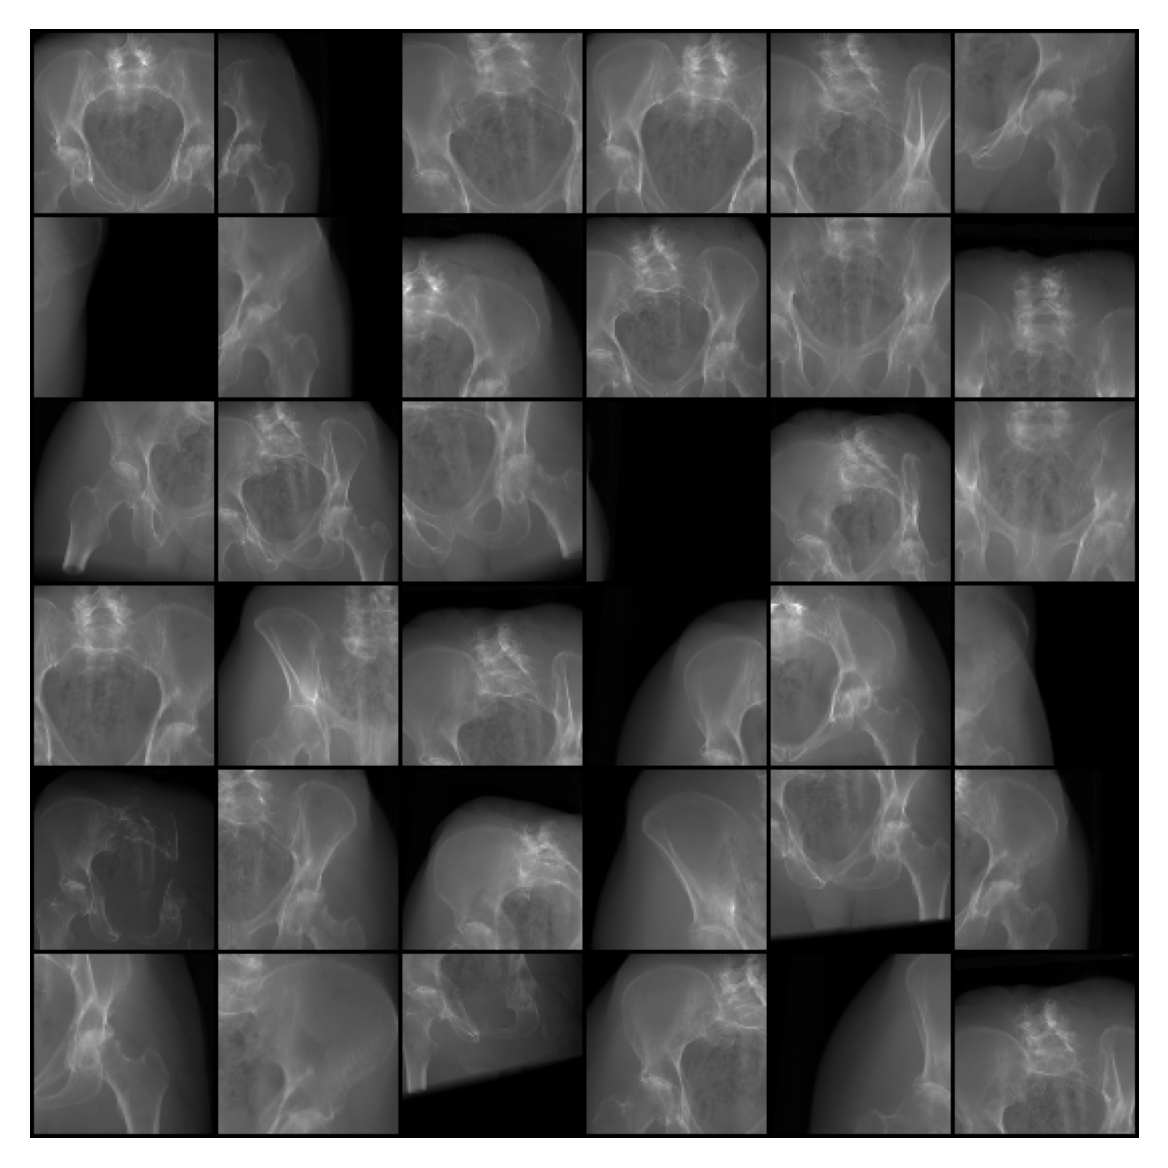

In [ ]:
#| eval: false
#| code-fold: true
#| fig-cap: DRRs from randomly sampled camera poses
import matplotlib.pyplot as plt
from diffdrr.drr import DRR
from torchvision.utils import make_grid

from diffpose.deepfluoro import DeepFluoroDataset

specimen = DeepFluoroDataset(1)
device = torch.device("cuda")

drr = DRR(
    specimen.volume,
    specimen.spacing,
    sdr=specimen.focal_len / 2,
    height=(1536 - 100) // 16,
    delx=0.194 * 16,
    x0=specimen.x0,
    y0=specimen.y0,
    reverse_x_axis=True,
).to(dtype=torch.float32, device=device)

isocenter_pose = specimen.isocenter_pose.to(device)
offset = get_random_offset(batch_size=36, device=device)
pose = isocenter_pose.compose(offset)

with torch.no_grad():
    img = drr(None, None, None, pose=pose, bone_attenuation_multiplier=2.5)
    img = (img - img.min()) / (img.max() - img.min())

plt.figure(dpi=300)
plt.imshow(make_grid(img.cpu(), nrow=6)[0], cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
# Rotation matrices are valid (det R = 1)
R = pose.get_matrix()[..., :3, :3].transpose(-1, -2)
R.det()

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

## Test-time optimization

### Sparse rendering

In [ ]:
#| export
from diffdrr.detector import make_xrays
from diffdrr.siddon import siddon_raycast
from diffdrr.utils import convert
from pytorch3d.transforms import se3_exp_map, se3_log_map


class SparseRegistration(torch.nn.Module):
    def __init__(self, drr, pose, features=None):
        super().__init__()
        self.drr = drr
        log = se3_log_map(pose.get_matrix())
        self.translation = torch.nn.Parameter(log[..., :3])
        self.rotation = torch.nn.Parameter(log[..., 3:])

        # Crop 10 pixels off the edge (i.e., use patch radius < 10 pixels)
        self.height = self.drr.detector.height
        self.f_height = self.height - 2 * 10

        if features is None:  # Sample all pixels equally
            features = torch.ones(
                self.height, self.height, device=self.rotation.device
            ) / (self.height**2)
        self.m = torch.distributions.categorical.Categorical(
            probs=features.squeeze()[10:-10, 10:-10].flatten()
        )

    def forward(self, n_patches, patch_size):
        """If n_patches is None, render the whole image."""

        if not hasattr(self.drr, "density"):
            self.drr.set_bone_attenuation_multiplier(
                self.drr.bone_attenuation_multiplier
            )

        # Make the mask
        if n_patches is not None:
            mask = torch.zeros(
                n_patches,
                self.height,
                self.height,
                dtype=torch.bool,
                device=self.rotation.device,
            )
            radius = patch_size // 2
            idxs = self.m.sample(sample_shape=torch.Size([n_patches]))
            idxs, jdxs = idxs // self.f_height + 10, idxs % self.f_height + 10

            idx = torch.arange(-radius, radius + 1, device=self.rotation.device)
            patches = torch.cartesian_prod(idx, idx).expand(n_patches, -1, -1)
            patches = patches + torch.stack([idxs, jdxs], dim=-1).unsqueeze(1)
            patches = torch.concat(
                [
                    torch.arange(n_patches, device=self.rotation.device)
                    .unsqueeze(-1)
                    .expand(-1, patch_size**2)
                    .unsqueeze(-1),
                    patches,
                ],
                dim=-1,
            )
            mask[
                patches[..., 0],
                patches[..., 1],
                patches[..., 2],
            ] = True
        else:
            mask = torch.ones(
                1,
                self.height,
                self.height,
                dtype=torch.bool,
                device=self.rotation.device,
            )

        # Get the source and target
        T = se3_exp_map(
            torch.concat([self.translation, self.rotation], dim=1)
        ).transpose(-1, -2)
        R = T[..., :3, :3]
        t = T[..., :3, 3]
        pose = RigidTransform(R, t, "matrix")
        source, target = make_xrays(
            pose,
            self.drr.detector.source,
            self.drr.detector.target,
        )

        # Render the sparse image
        target = target[mask.any(dim=0).view(1, -1)]
        img = siddon_raycast(source, target, self.drr.density, self.drr.spacing)
        return img, mask

    def get_rotation(self):
        T = se3_exp_map(
            torch.concat([self.translation, self.rotation], dim=1)
        ).transpose(-1, -2)
        R = T[..., :3, :3]
        return convert(R, "matrix", "euler_angles", output_convention="ZYX")

    def get_translation(self):
        T = se3_exp_map(
            torch.concat([self.translation, self.rotation], dim=1)
        ).transpose(-1, -2)
        t = T[..., :3, 3]
        return t

### Vectorized multiscale NCC

For computing multiscale NCC on sparse renderings.

In [ ]:
#| exporti
def preprocess(x, eps=1e-4):
    x = (x - x.min()) / (x.max() - x.min() + eps)
    return (x - 0.3080) / 0.1494


def pred_to_patches(pred_img, mask, n_patches, patch_size):
    return pred_img.expand(-1, n_patches, -1)[..., mask[..., mask.any(dim=0)]].reshape(
        1, n_patches, -1
    )


def img_to_patches(img, mask, n_patches, patch_size):
    return img.expand(-1, n_patches, -1, -1)[..., mask].reshape(1, n_patches, -1)


def mask_to_img(img, mask):
    return img[..., mask.any(dim=0)]


def vector_to_img(pred_img, mask):
    patches = [pred_img]
    filled = torch.zeros(1, 1, *mask[0].shape, device=pred_img.device)
    filled[...] = torch.nan
    for idx in range(len(mask)):
        patch = pred_img[:, mask[idx][mask.any(dim=0)]]
        filled[..., mask[idx]] = patch
        patches.append(patch)
    return filled

In [ ]:
#| export
class VectorizedNormalizedCrossCorrelation2d(torch.nn.Module):
    def __init__(self, eps=1e-4):
        super().__init__()
        self.eps = eps

    def forward(self, img, pred_img, mask, n_patches, patch_size):
        pred_img = preprocess(pred_img).unsqueeze(0)
        sub_img = mask_to_img(img, mask)
        pred_patches = pred_to_patches(pred_img, mask, n_patches, patch_size)
        img_patches = img_to_patches(img, mask, n_patches, patch_size)

        local_ncc = self.forward_compute(pred_patches, img_patches)
        global_ncc = self.forward_compute(pred_img, sub_img)
        return (local_ncc + global_ncc) / 2

    def forward_compute(self, x1, x2):
        assert x1.shape == x2.shape, "Input images must be the same size"
        x1, x2 = self.norm(x1), self.norm(x2)
        ncc = (x1 * x2).mean(dim=[-1, -2])
        return ncc

    def norm(self, x):
        mu = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, correction=0) + self.eps
        std = var.sqrt()
        return (x - mu) / std

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()